In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns


# load ModelBuilder into the worksheet
%run -i handy_code/ModelBuilder.py

# -------------------------------
# Load and Prepare the Dataset
# -------------------------------
df = pd.read_csv("SGSC_Weather_Sensor_Data.csv")

# FIX: Convert 'Time' column to datetime objects
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d%H%M%S')

# Drop non-numeric and irrelevant columns
non_numeric = ['DeviceID', 'EventID', 'Time', 'LocationID', 'Latitude', 'Longitude']
df_clean = df.drop(columns=non_numeric, errors='ignore')
df_clean = df_clean.dropna()

# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print(f"\nData ready for modeling. Shape: {X_scaled.shape}")

# =========================================================
# NEW: PyTorch Autoencoder Implementation (Using ModelBuilder)
# =========================================================

# 1. Define the Autoencoder Architecture
class IoTAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_list):
        super(IoTAutoencoder, self).__init__()

        # Encoder
        layers = []
        in_dim = input_size
        for h_dim in hidden_list:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU(True))
            in_dim = h_dim
        self.encoder = nn.Sequential(*layers)

        # Decoder (Reverse of Encoder)
        hidden_list.reverse()
        decoder_layers = []
        for h_dim in hidden_list[1:]:
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU(True))
            in_dim = h_dim
        decoder_layers.append(nn.Linear(in_dim, input_size)) # Output layer
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Data ready for modeling. Shape: (742141, 8)


In [9]:
# 2. Prepare data for PyTorch (Split Data)
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Training Data Loader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Validation Data Loader
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

input_dim = X_scaled.shape[1]

# 3. Initialize model and ModelBuilder
ae_model = IoTAutoencoder(input_dim, hidden_list=[32, 16, 8])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)

ae_builder = ModelBuilder(ae_model, loss_fn, optimizer, print_loss_freq=10)
# FIX: Provide both train and validation loaders
ae_builder.set_loaders(train_loader, val_loader=val_loader)

# -------------------------------
# Define Models for Comparison
# -------------------------------
CONTAMINATION_RATE = 0.02
models = {
    "IsolationForest": IsolationForest(
        n_estimators=100, contamination=CONTAMINATION_RATE, random_state=42, n_jobs=-1
    ),
    "LocalOutlierFactor": LocalOutlierFactor(
        n_neighbors=20, contamination=CONTAMINATION_RATE, novelty=True, n_jobs=-1
    ),
}

# -------------------------------
# Train and Predict (WITH BENCHMARKING)
# -------------------------------\
results = {}
latency_ms = {}

print("\n Running models...")

# 1. Isolation Forest
print("→ Isolation Forest")
t_start = time.time()
iso = models["IsolationForest"].fit(X_scaled)
t_end = time.time()
latency_ms["IsolationForest_Train"] = (t_end - t_start) * 1000

t_start = time.time()
iso_pred = iso.predict(X_scaled)
t_end = time.time()
latency_ms["IsolationForest_Inference"] = (t_end - t_start) * 1000
iso_scores = np.where(iso_pred == -1, 1, 0)
results["IsolationForest"] = iso_scores


# 2. Local Outlier Factor
print("→ Local Outlier Factor")
t_start = time.time()
lof = models["LocalOutlierFactor"].fit(X_scaled)
t_end = time.time()
latency_ms["LocalOutlierFactor_Train"] = (t_end - t_start) * 1000

t_start = time.time()
lof_pred = lof.predict(X_scaled)
t_end = time.time()
latency_ms["LocalOutlierFactor_Inference"] = (t_end - t_start) * 1000
lof_scores = np.where(lof_pred == -1, 1, 0)
results["LocalOutlierFactor"] = lof_scores

# 3. AutoEncoder (Deep Learning) - Using ModelBuilder
print("→ AutoEncoder (Deep Learning) - Using ModelBuilder.py")
N_EPOCHS = 50

t_start = time.time()
ae_builder.train(n_epochs=N_EPOCHS)
t_end = time.time()
latency_ms["AutoEncoder_Train"] = (t_end - t_start) * 1000

t_start = time.time()
reconstructions = ae_builder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - reconstructions), axis=1)
t_end = time.time()
latency_ms["AutoEncoder_Inference"] = (t_end - t_start) * 1000

threshold = np.percentile(reconstruction_error, 100 * (1 - CONTAMINATION_RATE))
ae_scores = (reconstruction_error > threshold).astype(int)
results["AutoEncoder"] = ae_scores


# -------------------------------
# Combine Results
# -------------------------------
results_df = pd.DataFrame(results)
results_df["Anomaly_Sum"] = results_df.sum(axis=1)
results_df["Anomaly_Consensus"] = (results_df["Anomaly_Sum"] >= 2).astype(int)

final_df = pd.concat([df_clean.reset_index(drop=True), results_df], axis=1)

print("\n Sample of Combined Results (clean data features + anomaly predictions):")
print(final_df.head(10))


 Running models...
→ Isolation Forest
→ Local Outlier Factor
→ AutoEncoder (Deep Learning) - Using ModelBuilder.py
Epoch 10, Training loss 0.0001, Validation loss 0.0001
Epoch 20, Training loss 0.0001, Validation loss 0.0001
Epoch 30, Training loss 0.0001, Validation loss 0.0001
Epoch 40, Training loss 0.0001, Validation loss 0.0005
Epoch 50, Training loss 0.0001, Validation loss 0.0001

 Sample of Combined Results (clean data features + anomaly predictions):
   AirTemp  AtmosphericPressure  GustSpeed  RelativeHumidity  Solar  \
0     10.7                99.14       3.92              58.2  294.0   
1     12.0                99.08       3.78              55.3  564.0   
2     13.2                99.04       4.03              52.7  609.0   
3     13.2                99.04       4.03              52.7  609.0   
4     13.2                99.04       4.03              52.7  609.0   
5     13.2                99.04       4.03              52.7  609.0   
6     14.1                99.00       


 Summary of Detected Anomalies:
                Model  Anomaly_Count  Normal_Count  Anomaly_Percentage
0     IsolationForest          14843        727298            2.000024
1  LocalOutlierFactor          12611        729530            1.699273
2         AutoEncoder          14843        727298            2.000024

 Streaming Performance Benchmarking:
                Model  Training_Latency_ms  Inference_Latency_ms  \
0     IsolationForest          3167.799950           2629.280329   
1  LocalOutlierFactor        382407.903671         315991.432428   
2         AutoEncoder        427272.368908            142.940521   

   Inference_Throughput_records_per_sec  
0                          2.822601e+05  
1                          2.348611e+03  
2                          5.191957e+06  


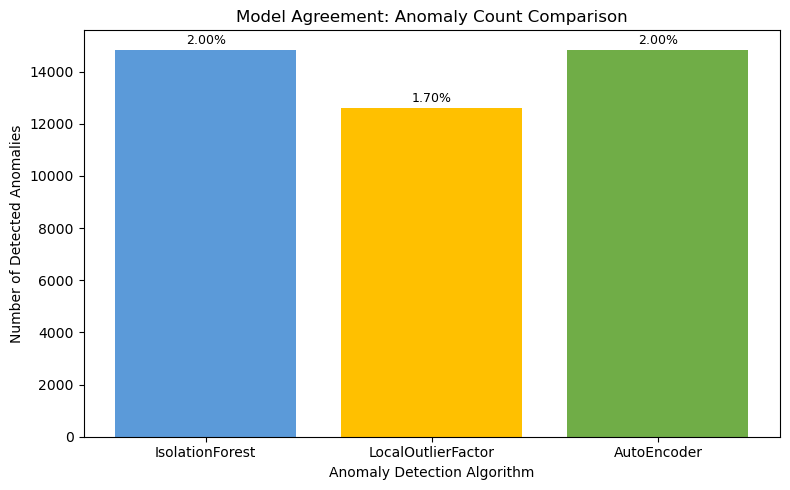

C:\Users\mongk\AppData\Local\Temp\ipykernel_30512\2299614090.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Inference_Throughput_records_per_sec', data=latency_summary, palette='viridis')


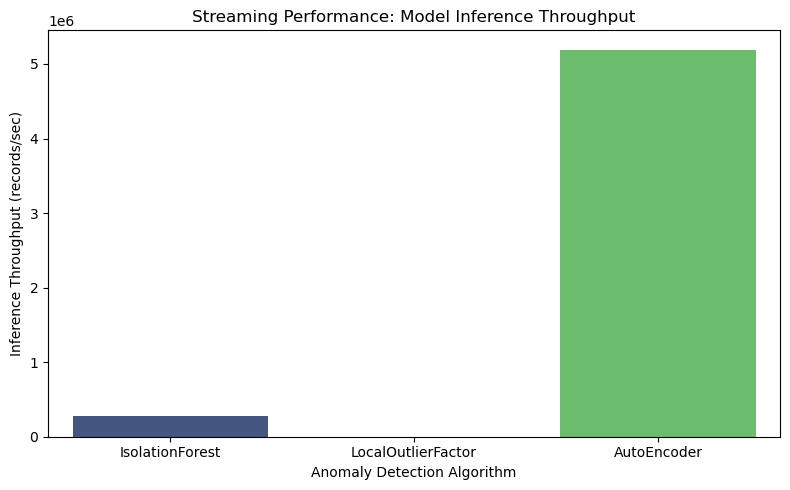

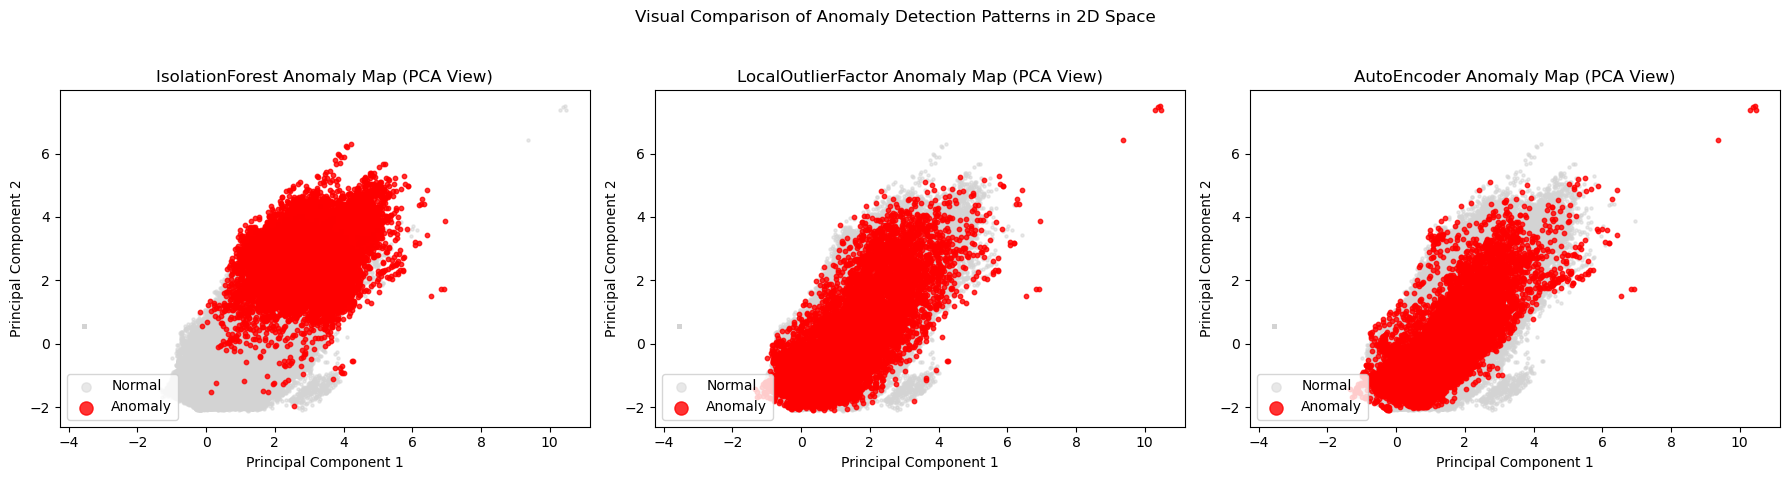


 All done! Results saved to 'SGSC_Weather_Anomaly_Results.csv'


In [10]:

# -------------------------------
# Model Comparison Summary
# -------------------------------
model_names = results_df.columns[:-2]
total_records = len(final_df)

summary = pd.DataFrame({
    "Model": model_names,
    "Anomaly_Count": [results_df[c].sum() for c in model_names],
    "Normal_Count": [len(results_df) - results_df[c].sum() for c in model_names],
    "Anomaly_Percentage": [100 * results_df[c].sum() / len(results_df) for c in model_names]
})

print("\n Summary of Detected Anomalies:")
print(summary)


# -------------------------------
# Performance Benchmarking (Latency)
# -------------------------------
latency_summary = pd.DataFrame({
    "Model": model_names,
    "Training_Latency_ms": [latency_ms[f"{m}_Train"] for m in model_names],
    "Inference_Latency_ms": [latency_ms[f"{m}_Inference"] for m in model_names],
    "Inference_Throughput_records_per_sec": [len(final_df) / (latency_ms[f"{m}_Inference"] / 1000) for m in model_names]
})

print("\n Streaming Performance Benchmarking:")
print(latency_summary)


# --- Anomaly Count Comparison (Bar Chart) ---
anomaly_counts = [results_df[c].sum() for c in model_names]
anomaly_percentages = [100 * count / total_records for count in anomaly_counts]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(model_names, anomaly_counts, color=['#5B9AD9', '#FFC000', '#70AD47'])

for bar, percentage in zip(bars, anomaly_percentages):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 100, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=9)

ax.set_title('Model Agreement: Anomaly Count Comparison')
ax.set_ylabel('Number of Detected Anomalies')
ax.set_xlabel('Anomaly Detection Algorithm')
plt.tight_layout()
plt.show() 


# --- Inference Throughput Comparison (Bar Chart - CRITICAL for streaming) ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Inference_Throughput_records_per_sec', data=latency_summary, palette='viridis')
plt.title('Streaming Performance: Model Inference Throughput')
plt.ylabel('Inference Throughput (records/sec)')
plt.xlabel('Anomaly Detection Algorithm')
plt.tight_layout()
plt.show() 

# -------------------------------
# Visual Comparison (PCA 2D)
# -------------------------------
# ---PCA Visualization (Scatter Plots) ---
# Project data for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
final_df["PCA1"] = X_pca[:, 0]
final_df["PCA2"] = X_pca[:, 1]

fig, axes = plt.subplots(1, len(model_names), figsize=(18, 5))
for i, model in enumerate(model_names):
    anomaly_mask = final_df[model] == 1
    
    # Plot normal points (light color)
    axes[i].scatter(final_df["PCA1"][~anomaly_mask], final_df["PCA2"][~anomaly_mask], 
                    c='lightgray', s=5, alpha=0.5, label='Normal')
    
    # Plot anomaly points (highlighted color)
    axes[i].scatter(final_df["PCA1"][anomaly_mask], final_df["PCA2"][anomaly_mask], 
                    c='red', s=10, alpha=0.8, label='Anomaly')
    
    axes[i].set_title(f'{model} Anomaly Map (PCA View)')
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')
    axes[i].legend(markerscale=3, loc='lower left')
    
plt.suptitle("Visual Comparison of Anomaly Detection Patterns in 2D Space")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

# -------------------------------
# Save Output
# -------------------------------
final_df.to_csv("SGSC_Weather_Anomaly_Results.csv", index=False)
print("\n All done! Results saved to 'SGSC_Weather_Anomaly_Results.csv'")